# Scaling SVD systems

## Loading the data

In [1]:
import pandas as pd
import numpy as np
data = pd.read_csv('data/ml-100k/u.data', sep='\t', names=["userId", "movieId", "rating", "timestamp"])
# data['userId'] = data['userId'].astype('str')
# data['movieId'] = data['movieId'].astype('str')
users = data['userId'].unique() #list of all users
movies = data['movieId'].unique() #list of all movies
print("Number of users", len(users))
print("Number of movies", len(movies))
data.head(10)

Number of users 943
Number of movies 1682


,userId,movieId,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596
5,298,474,4,884182806
6,115,265,2,881171488
7,253,465,5,891628467
8,305,451,3,886324817
9,6,86,3,883603013


Splitting the data into train and test (test set is 20% of all the data)

In [2]:
from sklearn.model_selection import train_test_split

train, test= train_test_split(data, test_size=0.2, random_state=42)

In [3]:
import scipy
import scipy.sparse as spsp
import scipy.sparse.linalg as spsplin
import scipy.linalg as splin

Constructing the user movie matrix from the train set

In [4]:
train_matrix = spsp.csr_matrix((train.rating.values.astype('f8'), 
                               (train.userId.values - 1, train.movieId.values - 1)), shape=(users.max(), movies.max()))
print(train_matrix.shape)

(943, 1682)


## Initial SVD system

Get averages needed for prediction

In [5]:
def get_r(matrix):
    r = matrix.sum(axis=0)
    for l in range(r.shape[1]):
        num = len(train_matrix[:, l].nonzero()[0])
        if num != 0:
            r[0, l] /= num
    return r

In [6]:
r = get_r(train_matrix)

Prepare our user movie matrix for SVD

In [7]:
def prepare_matrix(matrix, r):
    prepared_matrix = matrix.copy()
    for i in range(len(prepared_matrix.indptr) - 1):
        prepared_matrix.data[prepared_matrix.indptr[i]:prepared_matrix.indptr[i + 1]] = \
        prepared_matrix.data[prepared_matrix.indptr[i]:prepared_matrix.indptr[i + 1]] - \
        r[0, prepared_matrix.indices[prepared_matrix.indptr[i]:prepared_matrix.indptr[i + 1]]]
    return prepared_matrix

In [8]:
prep_mat = prepare_matrix(train_matrix, r)

Compute SVD (rank=14 was chosen empirically)

In [9]:
rank = 14
U, S, Vt = spsplin.svds(prep_mat, k=rank)

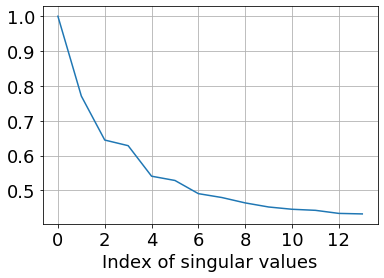

In [10]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

plt.plot(S[::-1] / S[-1])
plt.xlabel("Index of singular values", fontsize=18)
plt.yticks(fontsize=18)
plt.xticks(fontsize=18)
plt.grid(True)

In [11]:
sqrt_S = np.power(scipy.linalg.diagsvd(S, S.shape[0], S.shape[0]), 0.5)

USVk = U @ sqrt_S.T @ sqrt_S @ Vt

In [12]:
def predict(USVk, r, i, j):
    pred = r[0, j] + USVk[i][j]
#     pred = r + U[i, :][np.newaxis, :] @ sqrt_S.T @ sqrt_S @ Vt[:, j][:, np.newaxis]
    return pred

Metrics for comparison

In [22]:
def mae(true, pred):
    return np.mean(np.absolute(true - pred))
def rmse(true, pred):
    return np.sqrt(np.mean(np.power(np.absolute(true - pred), 2)))

In [14]:
true = test['rating'].values

In [15]:
def pred_batch(batch, USVk, r):
    pred = []
    for _,row in batch.iterrows():
        user = row['userId'] - 1
        item = row['movieId'] - 1
        pred.append(predict(USVk, r, user, item))
    pred = np.array(pred)
    return pred

Check if initial SVD system works

In [16]:
pred = pred_batch(test, USVk, r)

In [17]:
mae(true, pred)

0.773034347160854

In [23]:
rmse(true, pred)

0.9810926126300655

Errors are not high. Everything works fine.
Let' go to the scaling of the system.

### SVD fold-in algorithm

In [24]:
def svd_fold_in_users(U, S, Vt, new_users):
    tmp = new_users @ Vt.T @ np.linalg.inv(S)
    new_U = np.concatenate((U, tmp), axis=0)
    return new_U, S, Vt

def svd_fold_in_films(U, S, Vt, new_films):
    tmp = np.linalg.inv(S) @ U.T @ new_films
    new_Vt = np.concatenate((Vt, tmp), axis=1)
    return U, S, new_Vt

### Incremental SVD algorithm

In [25]:
def svd_concat_new_films(U, S, Vt, new_films, rank=14):
    V = Vt.T
    tmp = U.T @ new_films
    tmp = np.concatenate((S, tmp), axis=1)
    U_f, S_f, Vt_f = spsplin.svds(tmp, k=rank-1, return_singular_vectors=True)
    S_f = splin.diagsvd(S_f, S_f.shape[0], S_f.shape[0])
    U_new = U @ U_f
    S_new = S_f
    V_f = Vt_f.T
    V_new = np.zeros((V.shape[0] + new_films.shape[1], V_f.shape[0]))
    V_new[:V.shape[0],:V.shape[1]] = V
    for i in range(1, V_new.shape[0] - V.shape[0]):
        V_new[V.shape[0]+i][V.shape[1]+i] = 1
    V_new = V_new @ V_f
    Vt_new = V_new.T
    return U_new, S_new, Vt_new

def svd_concat_new_users(U, S, Vt, new_users, rank=14):
    V = Vt.T
    tmp = new_users @ V
    tmp = np.concatenate((S, tmp), axis=0)
    U_h, S_h, Vt_h = spsplin.svds(tmp, k=rank-1, return_singular_vectors=True)
    S_h = splin.diagsvd(S_h, S_h.shape[0], S_h.shape[0])
    V_new = V @ Vt_h.T
    S_new = S_h
    U_t = U.T
    U_new = np.zeros((U.shape[0] + new_users.shape[0], U_h.shape[0]))
    U_new[:U.shape[0],:U.shape[1]] = U
    for i in range(1, U_new.shape[0] - U.shape[0]):
        U_new[U.shape[0]+i][U.shape[1]+i] = 1
    U_new = U_new @ U_h
    Vt_new = V_new.T
    return U_new, S_new, Vt_new

## Experiments

To check our algorithms for scaling we conduct several experiments on how MAE and RMSE depend on the initial size of SVD. We cut the matrix into 2 pieces and compute SVD of the first part, then scale the SVD using the above mentioned methods then try to predict the test data using the modified SVD and measure MAE and RMSE. We also measure time of computing each method.

In [26]:
film_nums = list(range(100, train_matrix.shape[0], 50)) + [train_matrix.shape[0]]

In [27]:
def test_method(method, film_nums, prep_mat, r, rank=14):
    maes = []
    rmses = []
    times = []
    for film_num in film_nums:
#         cut_matrix = train_matrix[:, :film_num]
#         cut_r = r[:, :film_num]
#         add_columns = train_matrix[:, film_num:]
#         add_r = r[:, film_num:]
#         prep_cut_mat = prepare_matrix(cut_matrix, cut_r)
#         prep_add_col = prepare_matrix(add_columns, add_r)
        prep_cut_mat = prep_mat[:, :film_num]
        prep_add_col = prep_mat[:, film_num:]
        
        U, S, Vt = spsplin.svds(prep_cut_mat, k=rank)
        S = scipy.linalg.diagsvd(S, S.shape[0], S.shape[0])
        
        t = %timeit -o -q method(U, S, Vt, prep_add_col)
        times.append(t.average)
        U, S, Vt = method(U, S, Vt, prep_add_col)
        sqrt_S = np.power(S, 0.5)
        USVk = U @ sqrt_S.T @ sqrt_S @ Vt
        
        pred = pred_batch(test, USVk, r)
        
        maes.append(mae(true, pred))
        rmses.append(rmse(true, pred))
    return maes, rmses, times

In [28]:
fold_in_maes, fold_in_rmses, fold_in_times = test_method(svd_fold_in_films, film_nums, prep_mat, r)

In [29]:
incremental_maes, incremental_rmses, incremental_times = test_method(svd_concat_new_films, film_nums, prep_mat, r)

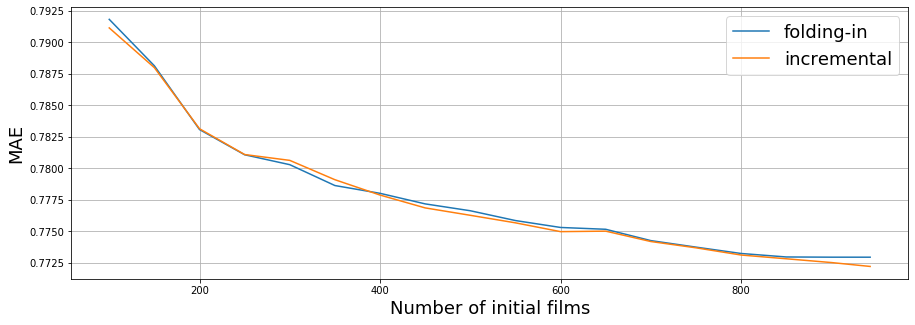

In [33]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(15,5))
plt.plot(film_nums, fold_in_maes, label="folding-in")
plt.plot(film_nums, incremental_maes, label="incremental")
# plt.plot(film_nums, fold_in_rmses, label="rmse")
plt.legend(fontsize=18)
plt.ylabel("MAE", fontsize=18)
plt.xlabel("Number of initial films", fontsize=18)
plt.grid()
plt.show()

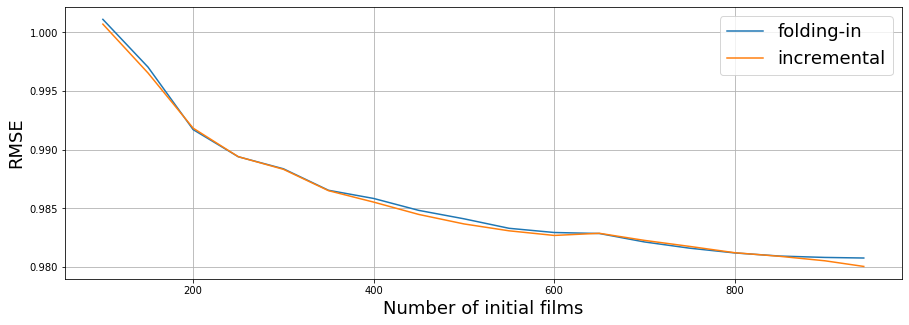

In [34]:
plt.figure(figsize=(15,5))
plt.plot(film_nums, fold_in_rmses, label="folding-in")
plt.plot(film_nums, incremental_rmses, label="incremental")
plt.legend(fontsize=18)
plt.ylabel("RMSE", fontsize=18)
plt.xlabel("Number of initial films", fontsize=18)
plt.grid()
plt.show()

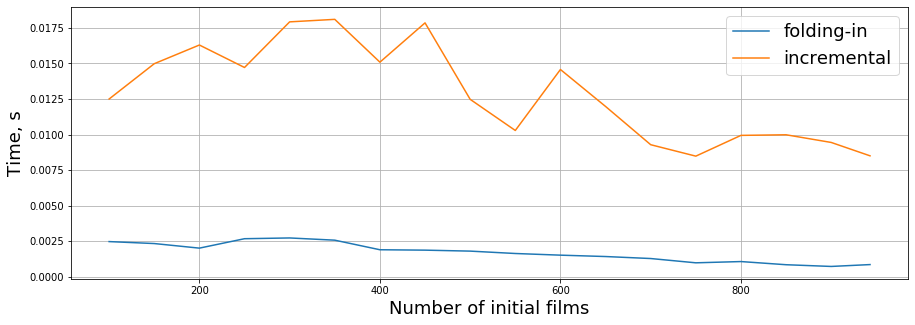

In [35]:
plt.figure(figsize=(15,5))
plt.plot(film_nums, fold_in_times, label="folding-in")
plt.plot(film_nums, incremental_times, label="incremental")
plt.legend(fontsize=18)
plt.ylabel("Time, s", fontsize=18)
plt.xlabel("Number of initial films", fontsize=18)
plt.grid()
plt.show()